<a href="https://colab.research.google.com/github/marcoplacenti/protein_generation/blob/main/final/redo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import torch, sys
import pandas as pd
import numpy as np  
from torch import nn
import torch.nn.functional as F
from torchtext import data
import torch.distributions as dist
import random
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
allocation_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Device where a torch.Tensor will be allocated

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/'Colab Notebooks'/project/

/content/drive/MyDrive/Colab Notebooks/project


In [ ]:
def get_data(dataset):
    '''Load dataset, make vocabulary and determine length of longest sequence'''
    data = pd.read_csv(dataset)

    data = data.iloc[:,0:].replace(np.nan, '<PAD>')

    longest_sequence_length = int(data['Sequence'].str.len().max()) # Find length of longest sequence

    # Create vocabulary - set containing all "conditioning tags"
    vocab = set()
    for col in data.columns[:-1]:
        vocab.update(data[col])

    # Add amino acid one letter code tokens to vocabulary
    for seq in data['Sequence']:
        seq = list(seq) # Make sequnce a list of amino acids
        vocab.update(seq)

    # Add "<PAD>" and "<EOS>" tokens to vocabulary
    vocab.update(['<PAD>'])
    vocab.update(['<EOS>'])

    # Determine the length of the sequence pre the amino acid sequence (conditional tags and null values)
    sequence_pre_amino_acids_length = data.shape[1] - 1

    return data, vocab, longest_sequence_length, sequence_pre_amino_acids_length

In [ ]:
def process_data(data, vocab, longest_sequence_length):
    '''Create encoder and decoder (between tokens and their IDs) and encode tokens to their IDs'''
    # Initialise encoding/decoding dictionaries (mapping between token and its ID)
    token_to_id, id_to_token = {}, {}
    
    # Store special tokens in encoding/decoding dictionaries
    token_to_id["<PAD>"] = 0
    id_to_token[0] = "<PAD>"

    token_to_id["<EOS>"] = 1
    id_to_token[1] = "<EOS>"

    # Store remaining tokens from vocabulary in mapping dictionaries
    for i, token in enumerate(vocab):
        cum_i = len(token_to_id.keys()) # Determine index of current token
        if token != "<PAD>" and token != "<EOS>":
            token_to_id[token] = cum_i
            id_to_token[cum_i] = token

    # Encode tokens with their IDs
    data_encoded = [] # Initialise list of encoded records
    for record in data.to_numpy():
        tags = record[:-1]
        sequence = record[-1]
        
        # Add "conditioning tag" IDs to encoding
        encoded_record = [token_to_id[tag] for tag in tags]

        # Add amino acid sequence IDs to encoding
        for char in sequence:
            encoded_record.append(token_to_id[char])
        
        # Add padding (ID = 0) to all records with a sequnce shorter than the longest
        # such that all records end up having the same length
        if len(sequence) < longest_sequence_length:
            for i in range(longest_sequence_length - len(sequence)):
                encoded_record.append(0)

        data_encoded.append(encoded_record)

    data_encoded = np.array(data_encoded) # Convert list of lists to numpy array

    return data_encoded, token_to_id, id_to_token

In [ ]:
def sample_categorical(lnprobs, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome log-probabilities
    :param temperature: Sampling temperature. 1.0 follows the given distribution,
        0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """

    if temperature == 0.0:
        return lnprobs.argmax()
    p = F.softmax(lnprobs / temperature, dim=0)
    return dist.Categorical(p).sample()

def sample_sentence(model, query, max_len = 140, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for _ in range(max_len - len(query)):
        #print(_)
        query_ = torch.zeros(max_len).to(torch.long)
        query_[:len(query)] = query
        #print(query_)
        #print(make_sequence_from_tokens(query_, id_to_token))
        output     = model(query_,1)


        #print(output.argmax())
        #print(output_test.view(-1, vocab_size))
        next_char_idx = sample_categorical(output.view(-1, vocab_size)[len(query) - 1], temperature) #0.5
        #print(next_char_idx)

        query = query.tolist()
        query.append(int(next_char_idx))
        query = torch.from_numpy(np.array(query))
        if next_char_idx == 1:
          break
        #print(make_sequence_from_tokens(query, id_to_token))
        #print(query.shape)
    #plt.figure(figsize=(40,10))
    #x_plt=output[:,0,0:10]
    #plt.imshow(x_plt.detach().cpu().numpy(), cmap='bwr_r')
    #plt.show()
    
    return query

def make_sequence_from_tokens(ids, id_to_token):
    sequence = map(lambda x: id_to_token[x], ids.tolist())
    return "".join(list(sequence))

In [ ]:
class ProGen(nn.Module):
  
    def __init__(self, embedding_dimension_size, vocab_size, attention_heads_count, n_layers, feedforward_dimension_size, longest_sequence_length, sequence_pre_amino_acids_length, full_sequence_length):
        super().__init__()

        self.embedding_dimension_size = embedding_dimension_size # The expected number of features in the input - the size of the embedding dimension
        self.feedforward_dimension_size = feedforward_dimension_size # Dimension size of feedforward layer
        self.longest_sequence_length = longest_sequence_length
        self.sequence_pre_amino_acids_length = sequence_pre_amino_acids_length
        self.full_sequence_length = full_sequence_length
        self.vocab_size = vocab_size

        # Initialise "token index to embedding look up table" with size equal to the number of different tokens
        self.token_index_to_embedding = nn.Embedding(vocab_size, embedding_dimension_size, padding_idx=0)
        # Initialise "sequence position to embedding look up table" with size equal to the length of the longest sequence
        self.position_to_positional_encoding = self.generate_position_to_positional_encoding_mapping()

        # Determine scalar that prevents dot product from becoming too large
        self.dot_product_scalar = 1/embedding_dimension_size ** 0.5

        self.layer_normalization = nn.LayerNorm(normalized_shape = embedding_dimension_size)
        transformer_block = nn.TransformerDecoderLayer(d_model=embedding_dimension_size, nhead=attention_heads_count, dim_feedforward=feedforward_dimension_size, dropout=0)
        self.transformer_stack = nn.TransformerDecoder(transformer_block, num_layers=n_layers, norm=self.layer_normalization)
        self.fully_connected_layer = nn.Linear(embedding_dimension_size, vocab_size)
        #self.toprobs = nn.Linear(embedding_dimension_size, vocab_size)
    
    def forward(self, x, batch_size):
        tgt_mask = self.generate_triangular_mask(self.full_sequence_length)
        memory = torch.zeros(self.full_sequence_length, batch_size, self.embedding_dimension_size) # The dimensions might be wrong
        position_matrix = self.generate_position_matrix(batch_size)
        positional_encodings = self.position_to_positional_encoding[position_matrix.view(-1)].view(batch_size, self.full_sequence_length, self.embedding_dimension_size) # Dimension: batch_size x full_sequence_length x embedding_dimension_size
        x = self.token_index_to_embedding(x) # Dimension: batch_size x full_sequence_length x embedding_dimension_size
        #print('x before add positional encoding', x.shape)
        #print(positional_encodings.shape)
        #print(x[0,60:])
        x = x + positional_encodings.squeeze(0)
        #print(x[0,60:])
        #print(positional_encodings[0,60:])
        #print('x after add positional encoding', x.shape)
        #x = x.permute(1, 0, 2)
        x = x.view(self.full_sequence_length, batch_size, self.embedding_dimension_size)
        x = self.transformer_stack(x, memory, tgt_mask=tgt_mask) # Dimension for input x must be: full_sequence_length x batch_size x embedding_dimension_size, output has the same dimensions
        # Determine token probabilities
        x = x.permute(1, 0, 2) # Dimension is now batch_size x full_sequence_length x embedding_dimension_size
        x = x.reshape(-1, self.embedding_dimension_size)
        x = self.fully_connected_layer(x)
        #print(x)
        x = x.view(batch_size, self.full_sequence_length, self.vocab_size)
        #print(x)
        x = F.softmax(x, dim=1)
        #print(x)
        return x


    def generate_triangular_mask(self, size):
        ''' Generate a triangular mask for the sequence. The masked positions (upper triangular part) are filled with float('-inf').
                  Unmasked positions (lower triangular part) are filled with float(0.0).
          '''
        mask = torch.triu(torch.full([size, size], - float('inf')), diagonal=1)

        return mask
            
    def generate_complete_mask(self, size):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = torch.empty(size, size)
        mask.fill_(float('-inf'))
        return mask
    
    def generate_position_to_positional_encoding_mapping(self):
        '''Generate mapping from positions to sinusoid positional encodings'''
        # Calculate positional encodings as described in article "Attention Is All You Need"
        positons = torch.arange(self.longest_sequence_length).unsqueeze(1) # Vector of positions
        embedding_dimension_indicies = torch.arange(self.embedding_dimension_size) # Vector of embedding dimension indicies
        angle_rates = 1 / torch.pow(10000, 2 * embedding_dimension_indicies/self.embedding_dimension_size)
        positional_encodings = torch.mul(positons, angle_rates)
        positional_encodings[:, 0::2] = torch.sin(positional_encodings[:, 0::2]) # Encode even dimensions using sine function
        positional_encodings[:, 1::2] = torch.cos(positional_encodings[:, 1::2]) # Encode odd dimensions using cosine function
        # Add special positional encoding vector with all zeroes (no postional encoding)
        positional_encodings = torch.cat([torch.zeros(self.embedding_dimension_size).unsqueeze(0), positional_encodings], dim=0)

        return positional_encodings

    def generate_position_matrix(self, batch_size):
        position_matrix = torch.zeros(batch_size, self.full_sequence_length, dtype=torch.long)

        for row_index in range(batch_size):
            row = data_encoded[row_index ,self.sequence_pre_amino_acids_length:]
            amino_acid_sequence_boolean = row != 0
            amino_acid_sequence_length = len(row[amino_acid_sequence_boolean])
            positions = torch.arange(1, amino_acid_sequence_length + 1)
            position_matrix[row_index ,self.sequence_pre_amino_acids_length:][amino_acid_sequence_boolean] = positions

        return position_matrix

In [ ]:
file = "dataset.csv"

data, vocab, longest_sequence_length, sequence_pre_amino_acids_length = get_data(file)
data_encoded, token_to_id, id_to_token = process_data(data, vocab, longest_sequence_length)

In [ ]:
vocab_size = len(vocab)
embedding_dimension_size = 32
feedforward_dimension_size = 32*4
attention_heads_count = 4
n_layer= 4
full_sequence_length = data_encoded.shape[1]
model = ProGen(embedding_dimension_size,
               vocab_size,
               attention_heads_count,
               n_layer,
               feedforward_dimension_size,
               longest_sequence_length,
               sequence_pre_amino_acids_length,
               full_sequence_length)

In [ ]:
data_encode=torch.from_numpy(data_encoded)
inputs  = torch.zeros(data_encode.shape[0], full_sequence_length).to(torch.long)
targets = torch.zeros(data_encode.shape[0], full_sequence_length).to(torch.long)
for i,entry in enumerate(data_encode):
  inputs[i,  0:len(entry)] = entry
  targets[i, 0:len(entry)-1] = entry[1:]
  targets[i, len(entry)-1] = 1  # <EOS> token

# Split into train and test dataset
combined = torch.stack([inputs, targets], dim=1)
train_size = int(0.8 * len(combined))
test_size = len(combined) - train_size
train_ds, test_ds = torch.utils.data.random_split(combined, [train_size, test_size])
train_x, train_y = combined[train_ds.indices][:, 0, :], combined[train_ds.indices][:, 1, :]
test_x, test_y   = combined[test_ds.indices][:, 0, :],  combined[test_ds.indices][:, 1, :]
tags_end = data.columns.get_loc("Sequence")

In [ ]:
QUERY = train_x[20,0:tags_end+10]
stats = { 'epoch':[], 'train_loss': [], 'train_perplexity': [], 'test_loss': [], 'test_perplexity': [] }
batch_size, epochs, clip = 16, 3000, 50

opt = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
for i in range(epochs):
    model.train()
    opt.zero_grad()
    # Sample a random batch of size `batch_size` from the train dataset
    #idxs = torch.randint(size=(batch_size,), low=0, high=len(train_x))
    idxs = np.random.randint(0, len(train_x), size=(batch_size,))
    output = model(train_x[idxs], batch_size)
    loss = criterion(output.view(-1, vocab_size), train_y[idxs].view(-1))
    nn.utils.clip_grad_norm_(model.parameters(), 50)
    loss.backward()
    opt.step()
    model.eval()
    idxs = np.random.randint(0, len(test_x), size=(batch_size,))
    output_test = model(test_x[idxs], batch_size)
    loss_on_test = criterion(output_test.view(-1, vocab_size), test_y[idxs].view(-1))
    perplexity = torch.exp(loss_on_test).item()
    # Update the stats and print something.
    stats['train_loss'].append(loss.item())
    stats['test_loss'].append(loss_on_test.item())
    stats['epoch'].append(i)
    stats['test_perplexity'].append(perplexity)
    if i % 10 == 0:
      sampled  = make_sequence_from_tokens(sample_sentence(model, QUERY,
                                                           full_sequence_length,
                                                           temperature = 1), id_to_token)
      print(i, loss.item(), perplexity, sampled)
      #plt.figure(figsize=(20,10))
  #    x_plt=output[:,0,200:250]
      #plt.imshow(x_plt.detach().cpu().numpy(), cmap='bwr_r')
      #plt.show()

0 7.221038341522217 1367.619140625 PF00159;<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>GO:0007218GO:0005576GO:0005179<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD> KW-0964 KW-0732KW-0527EukaryotaMetazoaChordataActinopteriSiluriformes (catfishes)Bagridae (bagrid catfishes)Tachysurus vachellii (Darkbarbel catfish) (Pelteobagrus vachellii)TachysurusMRLRANVCVGSpheniscidae (penguins)Hypophthalmichthys molitrix (Silver carp) (Leuciscus molitrix)ParamormyropsCalypte anna (Anna's hummingbird) (Archilochus anna)CrocutaRhinopithecus roxellana (Golden snub-nosed monkey) (Pygathrix roxellana)RhinogobiusCanis lupus (Gray wolf)GO:0032094CastorPeriophthalmusSemionotiformesTetraodonGO:0071821Anabarilius grahami (Kanglang fish) (Barilius grahami)Marmota monax (Woodchuck)Hylobatidae (gibbons)Cuculus canorus (common cuckoo)Lates calcarifer (Barramundi) (Holocent

KeyboardInterrupt: ignored

In [ ]:
output[4].argmax()

tensor(72391)

In [ ]:
train_y[idxs].shape

torch.Size([8, 179])

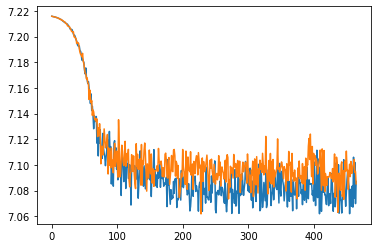

In [ ]:
plt.plot(stats['epoch'], stats['train_loss'])
plt.plot(stats['epoch'], stats['test_loss'])
plt.show()

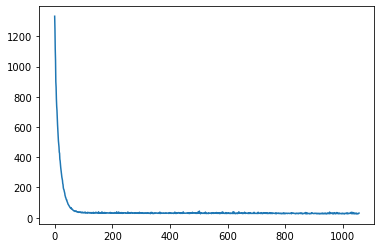

In [ ]:
plt.plot(stats['epoch'], stats['test_perplexity'])
plt.show()

In [ ]:
token_to_id['<PAD>']

0

In [ ]:
model

ProGen(
  (token_index_to_embedding): Embedding(1361, 128, padding_idx=0)
  (layer_normalization): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (transformer_stack): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=100, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=100, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dr

In [ ]:
output.shape

torch.Size([2864, 1361])

In [ ]:
output[0:1,0:,].argmax()

tensor(141)

In [ ]:
len(vocab)

1361

In [ ]:
id_to_token[141]

'GO:0005576'

In [ ]:
output_test.view(-1, vocab_size).shape

torch.Size([2864, 1361])

In [ ]:
len(output.view(-1, vocab_size))

2864

In [ ]:
output[1]

tensor([[0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
        ...,
        [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625]],
       grad_fn=<SelectBackward>)

In [ ]:
token_to_id['PF00159;']

KeyError: ignored

In [ ]:
token_to_id['A']

383

In [ ]:
inputs[1]

tensor([ 307,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  816, 1223,   50,    0,    0,    0,    0,    0,    0,
         160,  860, 1089,  965, 1304,  966,  335, 1127, 1261, 1096,    0, 1285,
         197, 1194,  928,  492,  639,  977,  959, 1060, 1092,  928,  977,  928,
         977,  492,  763, 1060, 1002,  619,  763,  763, 1060,  619,  492,  639,
         977,  959,  492, 1238, 1060, 1173, 1021, 1060,  277, 1021, 1060,  977,
        1021,  592,  883,  959, 1060, 1021, 1021,  226,  226,  763, 1060,  277,
        1173, 1173,  977, 1060,  763,  592,  639, 1173,  492, 1238,  763,  492,
         599,  592,  283,  592, 1173,  959,  277,  592,  883,  599, 1021,  883,
         599, 1092, 1002,  977,  883, 1092,  763,  928,  592,  226,  977,  599,
         226,  977,  492, 1021,  959,  9

In [ ]:
targets[1]

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  816, 1223,   50,    0,    0,    0,    0,    0,    0,  160,
         860, 1089,  965, 1304,  966,  335, 1127, 1261, 1096,    0, 1285,  197,
        1194,  928,  492,  639,  977,  959, 1060, 1092,  928,  977,  928,  977,
         492,  763, 1060, 1002,  619,  763,  763, 1060,  619,  492,  639,  977,
         959,  492, 1238, 1060, 1173, 1021, 1060,  277, 1021, 1060,  977, 1021,
         592,  883,  959, 1060, 1021, 1021,  226,  226,  763, 1060,  277, 1173,
        1173,  977, 1060,  763,  592,  639, 1173,  492, 1238,  763,  492,  599,
         592,  283,  592, 1173,  959,  277,  592,  883,  599, 1021,  883,  599,
        1092, 1002,  977,  883, 1092,  763,  928,  592,  226,  977,  599,  226,
         977,  492, 1021,  959,  977, 12

In [ ]:
model()

TypeError: ignored